# Transformers and Large Language Models
Transformers such as BERT or BART can model text data, sequences of tokens. The example below uses GLUE benchmark addressing several difficult problems in Natural Language Processing.

## GLUE Benchmark
The <a href="https://gluebenchmark.com" target="_blank">GLUE benchmark</a>
 has been introduced as a collection of tools and datasets for evaluating the performance models across a list of tasks. This benchmark includes many sentence understanding tasks that are based on various datasets of differing size, text type, and difficulty levels.
- Single sentence tasks
  1. CoLA: The Corpus of Linguistic Acceptability dataset - consists of English acceptability judgments drawn from articles on linguistic theory
  2. SST-2: The Stanford Sentiment Treebank dataset - includes sentences from movie reviews and human annotations of their sentiment with pos/neg labels
- Similarity and paraphrase tasks
  1. MRPC: The Microsoft Research Paraphrase Corpus dataset - examines whether the sentences in a pair are semantically equivalent
  2. QQP: The Quora Question Pairs dataset - decides whether a pair of questions is semantically equivalent
  3. STS-B: The Semantic Textual Similarity Benchmark dataset - collection of sentence pairs drawn from news headlines, with a similarity score between 1 and 5
- Inference tasks
  1. MNLI: The Multi-Genre Natural Language Inference corpus - a collection of sentence pairs with textual entailment. The task is to predict whether the text entails a hypothesis (entailment), contradicts the hypothesis (contradiction), or neither (neutral)
  2. QNLI: Question Natural Language Inference dataset - a converted version of SquAD. The task is to check whether a sentence contains the answer to a question.
  3. RTE: The Recognizing Textual Entailment dataset - a task of textual entailment challenges combining data from various sources; similar to the previous QNLI dataset, where the task is to check whether a first text entails a second one
  4. WNLI: The Winograd Natural Language Inference schema challenge - a pronoun resolution task linking a pronoun and a phrase in a sentence

GLUE benchmark <a href="https://huggingface.co/datasets/glue" target="_blank">dataset details</a>

Let's see a classifier example using BERT model.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
import numpy as np
import pandas as pd
import os

MODEL_PATH= '/EP_models/'
os.environ['HF_HOME']= MODEL_PATH  # before import transformers
os.environ['HF_DATASETS_CACHE']= MODEL_PATH  # dataset cache

os.environ['CUDA_VISIBLE_DEVICES']= '0'  # assume single GPU

import transformers

# filter warnings
transformers.logging.set_verbosity_error()

print(f'transformers version= {transformers.__version__}')

transformers version= 4.36.2


In [3]:
import torch

# set GPGPU device
Device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()
print(torch.cuda.get_device_name(0))

NVIDIA RTX 3500 Ada Generation Laptop GPU


In [4]:
# dataset
df = pd.read_csv("/EP_datasets/cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None,
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

print(df.shape)

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences_tr = ["[CLS] " + s + " [SEP]" for s in df.sentence.values]

# labels
df_labels_tr = df.label.values
print('balance:', np.unique(df_labels_tr, return_counts=True))

(8551, 4)
balance: (array([0, 1], dtype=int64), array([2528, 6023], dtype=int64))


In [6]:
from transformers import BertTokenizer

# Download the tokenizer for a pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts_tr = [tokenizer.tokenize(s) for s in sentences_tr]

# sanity
print ('Tokenized:',tokenized_texts_tr[0])

# longest sequence
print('longest seq=', np.array([len(t) for t in tokenized_texts_tr]).max())

Tokenized: ['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']
longest seq= 47


In [7]:
# Pad input tokens to top MAX_LEN which is a bit longer than the longest input sequence
MAX_LEN = 64

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
X_ids_tr = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_tr]

# since PAD is 0, top the sequence to MAX_LEN with 0
print('pad id=', tokenizer.convert_tokens_to_ids('[PAD]'))

for i, seq in enumerate(X_ids_tr):
    n = MAX_LEN-len(seq)
    X_ids_tr[i] += [0]*n

print(len(X_ids_tr[3]))

pad id= 0
64


In [8]:
# Create an attention mask of 1s for each token followed by 0s for padding
def get_masks(_X):
    attention_masks = []
    for seq in _X:
        attention_masks += [[float(_>0) for _ in seq]]
    return attention_masks

In [9]:
# Prepare dataset, tensors and iterator
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X_ids_tr, df_labels_tr, random_state=0, test_size=0.1)
mask_tr, mask_val, _, _ = train_test_split(get_masks(X_ids_tr), X_ids_tr, random_state=0, test_size=0.1)

X_tr, X_val, y_tr, y_val = torch.tensor(X_tr), torch.tensor(X_val), torch.tensor(y_tr), torch.tensor(y_val)
mask_tr, mask_val = torch.tensor(mask_tr), torch.tensor(mask_val)

In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 32

dataset_tr = TensorDataset(X_tr, mask_tr, y_tr)
dataloader_tr = DataLoader(dataset_tr, sampler=RandomSampler(dataset_tr), batch_size=BATCH_SIZE)

dataset_val = TensorDataset(X_val, mask_val, y_val)
dataloader_val = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=BATCH_SIZE)

In [11]:
from transformers import BertConfig, BertModel, BertForSequenceClassification

# BERT model and configuration
model = BertModel(BertConfig())

print(model.config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [12]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(Device)  # displays the entire neural network

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
# 'weight' parameters 'weight_decay_rate' of 0.01, 'bias' parameters 'weight_decay_rate' is 0.0
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.1},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
]

In [14]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 4

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps = 1e-8)

total_steps = len(dataloader_tr)*EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [15]:
def accuracy_logits(_logits, _y):
    ypred = [0 if _[0]>_[1] else 1 for _ in _logits]
    return np.sum([ypred[_]==_y[_] for _ in range(len(ypred))]) / len(ypred)

In [16]:
%%time

# manual training loop, fine-tune
loss_train = []
for _ in range(EPOCHS):
    model.train()  # set to training mode
    cost, n = 0, 1
    for n, batch in enumerate(dataloader_tr):
        X_b, mask_b, y_b = tuple(t.to(Device) for t in batch)  # send batch to device
        optimizer.zero_grad()       
        # NN forward
        outputs = model(X_b, token_type_ids=None, attention_mask=mask_b, labels=y_b)
        loss = outputs['loss']
        loss_train += [loss.item()]    
        cost += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    print(f'Train loss= {cost/n:.3f}')
    # Evaluation
    model.eval()  # set to non-training mode
    acc = 0
    for n, batch in enumerate(dataloader_val):
        X_b, mask_b, y_b = tuple(t.to(Device) for t in batch)
        with torch.no_grad():
            logits = model(X_b, token_type_ids=None, attention_mask=mask_b)
        acc += accuracy_logits(logits['logits'].detach().cpu().numpy().tolist(), y_b.to('cpu').tolist())
    print(f'Validation accuracy= {acc/n:.3f}')

Train loss= 0.508
Validation accuracy= 0.845
Train loss= 0.313
Validation accuracy= 0.880
Train loss= 0.183
Validation accuracy= 0.880
Train loss= 0.115
Validation accuracy= 0.875
CPU times: total: 2min 28s
Wall time: 2min 28s


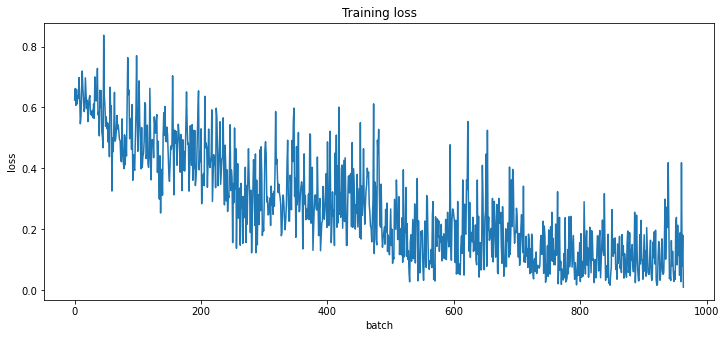

In [17]:
# training progress
plt.figure(figsize=(12,5), dpi=72)
plt.xlabel('batch')
plt.ylabel('loss')
plt.title('Training loss')
plt.plot(loss_train)
plt.show()

In [18]:
# test performance
df = pd.read_csv("/EP_datasets/cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None,
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences_ts = ["[CLS] " + s + " [SEP]" for s in df.sentence.values]

# labels
df_labels_ts = df.label.values
print('balance:', np.unique(df_labels_ts, return_counts=True))

tokenized_texts_ts = [tokenizer.tokenize(s) for s in sentences_ts]

X_ids_ts = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_ts]

# pad 0
for i, seq in enumerate(X_ids_ts):
    n = MAX_LEN-len(seq)
    X_ids_ts[i] += [0]*n

X_ts, y_ts, mask_ts = torch.tensor(X_ids_ts), torch.tensor(df_labels_ts), torch.tensor(get_masks(X_ids_ts))
dataset_ts = TensorDataset(X_ts, mask_ts, y_ts)
dataloader_ts = DataLoader(dataset_ts, sampler=SequentialSampler(dataset_ts), batch_size=BATCH_SIZE)

balance: (array([0, 1], dtype=int64), array([162, 354], dtype=int64))


In [19]:
# predict
y_logits, y_ts = [], []
model.eval()
for batch in dataloader_ts:
    X_b, mask_b, y_b = tuple(t.to(Device) for t in batch)
    with torch.no_grad():
        logits = model(X_b, token_type_ids=None, attention_mask=mask_b)
    logits = logits['logits'].detach().cpu().numpy()
    y_logits += logits.tolist()
    y_ts += y_b.to('cpu').tolist()

print(f'CoLa benchmark accuracy= {accuracy_logits(y_logits, y_ts):.2f}')

CoLa benchmark accuracy= 0.81


***
## LLM Example
The illustration below demonstrates the application of a BERT NER model to identify entity names from the movie reviews dataset. By utilizing $\texttt{I-MISC}$ entities for extracting movie titles and specifying a length of 4, unique movie titles can be obtained. It is important to refine the process to handle cases where movie names consist of a mix of lowercase and uppercase words, as seen in the example of the title $\texttt{'Gone with the Wind'}$.

In [20]:
from collections import defaultdict
import csv
import re

from nltk import word_tokenize

# Locate and load the data file
Reviews, Sentiments = [], []
with open('/EP_datasets/movie_data.csv', 'r', encoding="utf8") as fin:
    reader = csv.reader(fin, delimiter=',', quotechar='"')
    header = next(reader)  # pass the header
    for line in reader:
        line[0] = re.sub('<br /><br />', ' ', line[0])  # HTML sourced reviews
        line[0] = re.sub(' \W+ ', ' ', line[0])  # Symbols
        Reviews += [line[0]]
        Sentiments += [int(line[1])]  # good to keep the class as integers

N = len(Reviews)

Reviews0 = [_ for i, _ in enumerate(Reviews) if Sentiments[i] == 0]
N0 = len(Reviews0)
Reviews1 = [_ for i, _ in enumerate(Reviews) if Sentiments[i] == 1]
N1 = len(Reviews1)

# Sanity check
print(f'Total reviews loaded {N}, N0={N0}, N1={N1}')

Total reviews loaded 50000, N0=25000, N1=25000


In [21]:
%%time

Reviews_tok = [word_tokenize(_) for _ in Reviews]

CPU times: total: 40.2 s
Wall time: 40.2 s


In [22]:
import os
MODEL_PATH= '/EP_models/'
os.environ['HF_HOME'] = MODEL_PATH  # before import transformers
os.environ['HF_DATASETS_CACHE'] = MODEL_PATH

from nltk import word_tokenize, pos_tag

import transformers
from transformers import pipeline

# filter warnings
transformers.logging.set_verbosity_error()

In [23]:
# dataset generator pipeline requires
def datasetR(_li):
    for _ in _li:
        yield _

dsR0, dsR1 = datasetR(Reviews0), datasetR(Reviews1)

In [24]:
nlp_ner = pipeline('ner', device=0)

In [25]:
%%time

dsR0, dsR1 = datasetR(Reviews0), datasetR(Reviews1)
Ner0 = [_ for _ in nlp_ner(dsR0)]
Ner1 = [_ for _ in nlp_ner(dsR1)]

CPU times: total: 26min 22s
Wall time: 26min 23s


In [26]:
def harmonize_words(_w):
    WORDS = ('and', 'of', 'on', 'the', 'to', 'with')
    for w in WORDS:
        _w = re.sub(r'(?i)^'+w+'$', w, _w)
    return _w

def check_ner(_result):
    _result = [_ for _ in _result if _['entity']=='I-MISC' and len(_['word']) > 1]
    if len(_result) == 0:
        return []
    ners = []
    ix1, w1 = _result[0]['index'], harmonize_words(_result[0]['word'])
    ner = w1
    for r in _result[1:]:
        ix2, w2 = r['index'], harmonize_words(r['word'])
        if ix2 == ix1+1:
            if w2[0] == '#':
                w2 = w1 + w2[len(w1):]
            else:
                ner += ' '+w2
        else:
            ners += [ner]
            ner = w2
        ix1, w1 = ix2, w2
    ners = [_ for _ in ners if _[0] != '#']
    return ners

In [27]:
from collections import defaultdict

Cnt0, Cnt1 = defaultdict(int), defaultdict(int)
for i, result in enumerate(Ner0):
    ners = check_ner(result)
    for ner in ners:
        Cnt0[ner] += 1
for i, result in enumerate(Ner1):
    ners = check_ner(result)
    for ner in ners:
        Cnt1[ner] += 1

In [28]:
# sentiment 0
ne0 = sorted(Cnt0.items(), key= lambda kv:kv[1], reverse=True)

# four or more letter words movies
ne0 = [_ for _ in ne0 if len(_[0].split(' ')) >= 4]
ne0[:20]

[('Mystery Science Theater 3000', 37),
 ('Lord of the Rings', 32),
 ('Gone with the Wind', 30),
 ('Nightmare on Elm Street', 29),
 ('House of the Dead', 28),
 ('Alone in the Dark', 23),
 ('the Cat in the Hat', 23),
 ('Night of the Living Dead', 17),
 ('the Blair Witch Project', 16),
 ('Silence of the Lamb', 16),
 ('Son of the Mask', 14),
 ('Sex and the City', 13),
 ('the Hands of Fate', 13),
 ('War of the Worlds', 13),
 ('Rev of the Zombie', 13),
 ('Know What You Did Last Summer', 13),
 ('Attack of the Killer Tomatoes', 13),
 ('Dawn of the Dead', 12),
 ('the Most Dangerous Game', 11),
 ('the Hills Have Eyes', 11)]

In [29]:
# sentiment 1
ne1 = sorted(Cnt1.items(), key= lambda kv:kv[1], reverse=True)

# four or more letter words movies
ne1 = [_ for _ in ne1 if len(_[0].split(' ')) >= 4]
ne1[:20]

[('Lord of the Rings', 42),
 ('Gone with the Wind', 40),
 ('Nightmare on Elm Street', 25),
 ('Never Say Never Again', 25),
 ('Tale of Two Sisters', 23),
 ('the Wizard of Oz', 20),
 ('Pick on South Street', 17),
 ('Return of the Jed', 17),
 ('Panic in the Streets', 16),
 ('the Post Always Rings Twice', 16),
 ('War of the Worlds', 16),
 ('Castle in the Sky', 16),
 ('Silence of the Lamb', 15),
 ('Night of the Living Dead', 15),
 ('the Texas Chain Massacre', 14),
 ('Written on the Wind', 14),
 ('Back to the Future', 13),
 ('the Man with the Golden Arm', 13),
 ('Shaun of the Dead', 13),
 ('Sex and the City', 13)]

In [30]:
# List the top movies with pos and neg sentiments
ne0top = [k for (k,v) in ne0[:50]]
ne1top = [k for (k,v) in ne1[:50]]
netop = set(ne0top) & set(ne1top)  # intersection operator symbol
ne0_x = sorted([k for k in netop], reverse=True)
ne0_y = [Cnt0[k] for k in netop]
ne1_x = sorted([k for k in netop], reverse=True)
ne1_y = [Cnt1[k] for k in netop]

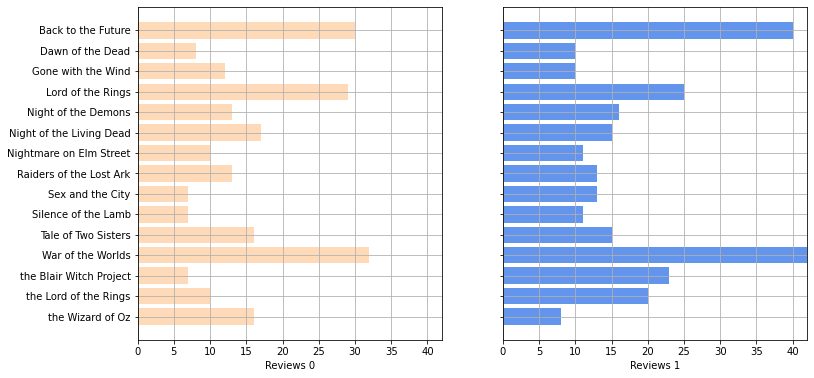

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
from matplotlib.ticker import MaxNLocator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=72)

ax1.barh(ne0_x, ne0_y, color='peachpuff')
ax2.barh(ne1_x, ne1_y, color='cornflowerblue')
ax2.set_yticklabels([])
ax1.set_xlabel('Reviews 0'); ax2.set_xlabel('Reviews 1'); ax1.grid(); ax2.grid()

# Integer y values
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlim(0, max(max(ne0_y), max(ne1_y)))
ax2.set_xlim(0, max(max(ne0_y), max(ne1_y)))

plt.savefig('fig_llm01.svg', dpi=300, bbox_inches='tight')